This notebook presents the parametrized parametrization of a Catmull Rom curve in three-dimensional space, at the beginning a few plots show the geometrical differences of the curve shape at concrete alpha values. Then, a simple animation uses the parameter space to visualize the relationship between the alpha and the changing torsion along the curve. 

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

import matplotlib.animation as animation 

In [3]:
from IPython import display 

In [4]:
import sys

sys.path.append('../../..')

In [5]:
from lib_spline.catmullrom import CatmullRom
from lib_spline.piecewise import Piecewise
from lib_spline.grid import alpha_param

In [6]:
from lib_param.interface.expression import Expression

### Alpha Values

In [7]:
points = np.array([
    
    (-1, -0.5, 1.0),
    (0, 2.3, 0.1),
    (0.15, 3.1, 0.5),
    (4, 1.3, -1.5)
])

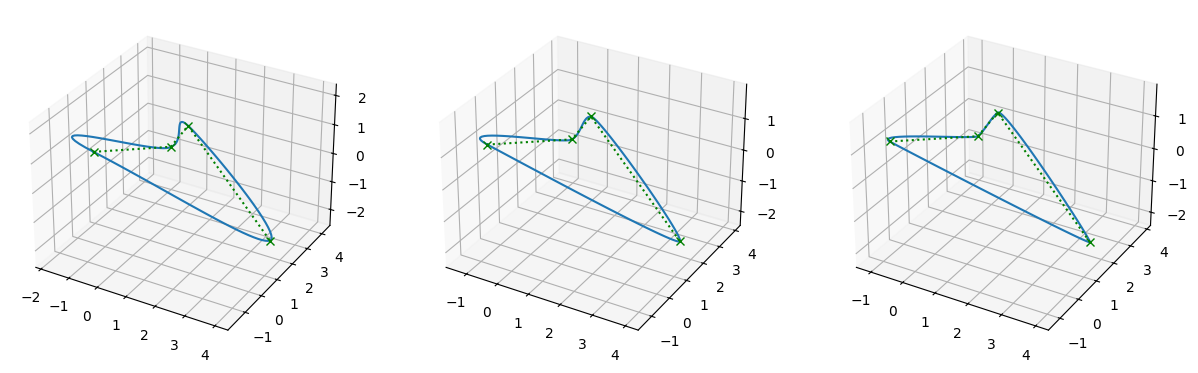

In [8]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

alphas = [0.01, 0.5, 1.0]

renders = []

for alpha, axs in zip(alphas, [ax1, ax2, ax3]):

    new_grid = alpha_param(alpha, points, closed = True)
    catmull = CatmullRom( points, new_grid, closed = True )
    tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 100)
    render = np.array([catmull.evaluate(t) for t in tetha])

    renders.append(render)

    axs.plot(*render.T)
    axs.plot(*points.T, 'x:g')
    axs.axis('equal');

plt.show()

### Perametrized Animation

In [9]:
# init data

new_grid = alpha_param(alpha, points, closed = True)
catmull = CatmullRom( points, new_grid, closed = True )
tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 100)
render = np.array([catmull.evaluate(t) for t in tetha])

In [10]:
e = Expression (catmull)

torsion = np.array( [ e.torsion(t1) for t1 in tetha ] )

start = np.array( [ np.array(e.normal(t1)) * torsion[idx] for idx, t1 in enumerate(tetha) ] )

In [11]:
def lerp(xs, ts, t):

    x_str, x_end = xs

    t_str, t_end = ts

    t_map = (t - t_str) / (t_end - t_str)

    return (1 - t_map) * x_str + t_map * x_end

In [12]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(15, 5))

axl = fig.add_subplot(1, 2, 1, projection='3d')
axr = fig.add_subplot(1, 2, 2)

# axes prop - right

axl.set_xlim3d([-3, 6])
axl.set_xlabel('X')

axl.set_ylim3d([-2, 4])
axl.set_ylabel('Y')

axl.set_zlim3d([-3, 6])
axl.set_zlabel('Z')

# axes prop - left

axr.set_ylim([-20, 20])

# left
line,  = axl.plot(*render.T)
Q      = axl.quiver(*render.T, *start.T, color=['r'], length=0.05)

# right
lineR, = axr.plot(tetha, torsion)

max_frames = 100

def init ():

    pass

def quiver_to_segments(X, Y, Z, 
                       u, v, w, 
                       l=1):

    segs = (X, Y, Z, X+v*l, Y+u*l, Z+w*l)

    segs = np.array(segs).reshape(6,-1)

    return [[[x, y, z], [u, v, w]] 
            for x, y, z, u, v, w in zip(*list(segs))]

def animate(frame_number, line):

    mid_frame = (max_frames / 2)

    if (frame_number < mid_frame):
        interpolator  = frame_number / max_frames
    else:
        interpolator  = 1.0 - (frame_number / max_frames)

    alpha = lerp([-0.5, 1], [0, 0.5], interpolator)

    new_grid = alpha_param(alpha, points, closed = True)
    catmull = CatmullRom( points, new_grid, closed = True )
    tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 100)
    render = np.array([catmull.evaluate(t) for t in tetha])

    e = Expression (catmull)

    line.set_data(render.T[0:2, :])
    line.set_3d_properties(render.T[2, :])

    torsion = np.array( [ e.torsion(t1) for t1 in tetha ] )

    normals = np.array( [ np.array(e.normal(t1)) * torsion[idx] for idx, t1 in enumerate(tetha) ] )

    segs = quiver_to_segments(*render.T ,*normals.T, 1)
    
    Q.set_segments(segs)

    # torsion plot -> right:

    lineR.set_ydata(torsion)

    return line, Q, lineR

anim = animation.FuncAnimation(fig, animate, frames =max_frames, fargs=[line], interval=20, blit=False)

fig.suptitle('Alpha Parametrization - Torsion on Normal', fontsize=14) 
  
video = anim.to_html5_video() 
  
html = display.HTML(video) 
  
display.display(html) 

plt.close() 